In [1]:
import os
import json 
import random
import numpy as np 
import pandas as pd
from tqdm import tqdm 
from PIL import Image
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms 
from transformers import ViTFeatureExtractor
from torch.utils.data import Dataset, DataLoader, random_split 
from torch.nn.functional import cross_entropy
from transformers import BertTokenizer, BertModel, ViTModel, BertConfig, AdamW
from transformers import BertLMHeadModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

C:\Users\omrav\AppData\Roaming\Python\Python311\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
C:\Users\omrav\AppData\Roaming\Python\Python311\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any 

cuda


In [2]:
class VQA_RAD_Dataset(Dataset):
    def __init__(self, json_dir, img_dir, transform=None):

        with open(json_dir, 'r') as file:
            self.data = json.load(file)

        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_dir , self.data[index]['image_name'])
        question = self.data[index]['question']
        answer = str(self.data[index]['answer'])

        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, question, answer

In [3]:
def custom_collate_fn(batch):
    images, questions, answers = zip(*batch)
    images = torch.stack(images)  # Stack images into a single tensor
    questions = list(questions)   # Keep questions as a list of strings
    answers = list(answers)       # Keep answers as a list of strings
    return images, questions, answers

image_dir = r"Dataset\VQA_RAD\VQA_RAD Image Folder"
json_dir = r"Dataset\VQA_RAD\VQA_RAD Dataset Public.json"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = VQA_RAD_Dataset(json_dir=json_dir, img_dir=image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn)

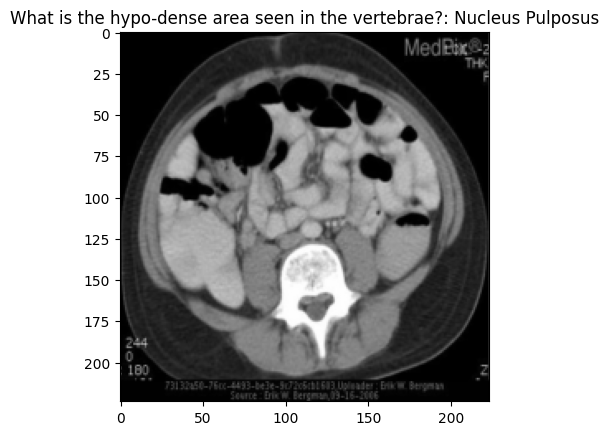

In [4]:
image, question, answer = dataset.__getitem__(-1)

image = image.permute(1, 2, 0).numpy()
plt.imshow(image)
plt.title(f"{question}: {answer}")
plt.show()

In [17]:
class VQAModel(nn.Module):
    def __init__(self, bert, vit, answer_decoder_config):
        super(VQAModel, self).__init__()

        # Store preloaded BERT and ViT models
        self.bert = bert
        self.text_encoder = nn.ModuleList(self.bert.encoder.layer[:6])  # First 6 layers of BERT
        self.multimodal_encoder = nn.ModuleList(self.bert.encoder.layer[6:])  # Last 6 layers of BERT
        self.image_encoder = vit  # Preloaded Vision Transformer

        # Answer Decoder with cross-attention enabled, initialized from the config
        self.answer_decoder = BertLMHeadModel(answer_decoder_config)

    def forward(self, input_ids, attention_mask, images, decoder_input_ids):
        # Step 1: Process Text Encoder (First 6 layers of BERT)
        text_embeddings = self._encode_text(input_ids, attention_mask)

        # Step 2: Process Image Encoder (ViT)
        image_embeddings = self.image_encoder(images).last_hidden_state

        # Step 3: Concatenate Text and Image Embeddings
        combined_embeddings = torch.cat((text_embeddings, image_embeddings), dim=1)

        # Step 4: Create Combined Attention Mask
        combined_attention_mask = torch.cat(
            [attention_mask, torch.ones((attention_mask.size(0), image_embeddings.size(1)), device=attention_mask.device)],
            dim=1
        )

        # Step 5: Process Multimodal Encoder (Last 6 layers of BERT)
        multimodal_embeddings = self._encode_multimodal(combined_embeddings, combined_attention_mask)

        # Output the multimodal embeddings to be used with the answer decoder for token-by-token generation
        return multimodal_embeddings

    def _encode_text(self, input_ids, attention_mask):
        # Initial text embeddings from input IDs using self.bert's embedding layer
        text_embeddings = self.bert.embeddings(input_ids=input_ids)
        
        # Expand attention mask to required shape for BERT encoder layers
        attention_mask_expanded = attention_mask.unsqueeze(1).unsqueeze(2).float()
        attention_mask_expanded = (1.0 - attention_mask_expanded) * -10000.0

        # Process through the first 6 layers of BERT for text encoding
        for layer in self.text_encoder:
            text_embeddings = layer(text_embeddings, attention_mask=attention_mask_expanded)[0]
        
        return text_embeddings

    def _encode_multimodal(self, combined_embeddings, combined_attention_mask):
        # Expand combined attention mask
        combined_attention_mask_expanded = combined_attention_mask.unsqueeze(1).unsqueeze(2).float()
        combined_attention_mask_expanded = (1.0 - combined_attention_mask_expanded) * -10000.0

        # Process through the last 6 layers of BERT for multimodal encoding
        for layer in self.multimodal_encoder:
            combined_embeddings = layer(combined_embeddings, attention_mask=combined_attention_mask_expanded)[0]

        return combined_embeddings


In [12]:
def train_vqa_model(model, dataloader, tokenizer, num_epochs=3, lr=1e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Optimizer
    optimizer = AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Dictionary to keep track of metrics
    metrics_history = {'loss': []}

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images, questions, answers = batch
            images = images.to(device)
            
            # Tokenize the questions and answers
            encoding = tokenizer(questions, padding='max_length', truncation=True, max_length=12, return_tensors='pt')
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)

            # Prepare the decoder input by starting with the [CLS] token
            decoder_input_ids = torch.tensor([[tokenizer.cls_token_id]] * input_ids.size(0), device=device)

            # Forward pass to get multimodal embeddings
            with torch.no_grad():
                multimodal_embeddings = model(input_ids, attention_mask, images, decoder_input_ids)

            # Generate answers using the answer decoder and calculate loss for each token
            max_answer_length = 20
            batch_loss = 0

            for batch_idx in range(multimodal_embeddings.size(0)):
                decoder_input_ids = torch.tensor([[tokenizer.cls_token_id]], device=device)
                target_ids = tokenizer.encode(answers[batch_idx], add_special_tokens=True)
                target_ids = torch.tensor(target_ids, device=device)

                answer_tokens = []

                for i in range(len(target_ids) - 1):  # Iterate through each token in target
                    outputs = model.answer_decoder(
                        input_ids=decoder_input_ids,
                        encoder_hidden_states=multimodal_embeddings[batch_idx].unsqueeze(0)
                    )
                    logits = outputs.logits[:, -1, :]  # Get the logits for the last generated token
                    next_token_id = target_ids[i + 1]  # Next token in the target sequence
                    
                    # Calculate loss for the current token
                    loss = criterion(logits, next_token_id.unsqueeze(0))
                    batch_loss += loss

                    # Update the decoder input with the next token
                    decoder_input_ids = torch.cat([decoder_input_ids, next_token_id.unsqueeze(0).unsqueeze(0)], dim=1)
                    
                    # Stop if [SEP] token is reached in the target sequence
                    if next_token_id.item() == tokenizer.sep_token_id:
                        break

            # Average loss for the batch
            batch_loss /= len(target_ids) - 1  # Divide by number of tokens to average

            # Backpropagation
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            total_loss += batch_loss.item()

        # Calculate average loss for the epoch
        avg_loss = total_loss / len(dataloader)
        metrics_history['loss'].append(avg_loss)  # Store the loss for this epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

    return metrics_history

In [21]:
def process_batch(batch, tokenizer):
    images, questions, answers = batch  # Extract images, questions, and answers
    encoding = tokenizer(
        questions,
        padding='max_length',
        truncation=True,
        max_length=12,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']
    images = images.to(torch.float32)  # Ensure images are float32
    return images, questions, answers, input_ids, attention_mask    

In [22]:
def test_vqa_model_on_batch(model, dataloader, tokenizer, max_answer_length=20):
    """
    Tests the VQAModel on a single batch from the dataloader.
    
    Parameters:
        model (VQAModel): The VQA model to test.
        dataloader (DataLoader): DataLoader containing the test data.
        tokenizer (BertTokenizer): Tokenizer for encoding and decoding.
        max_answer_length (int): Maximum length for generated answers.
    """
    # Ensure model is on the correct device
    device = next(model.parameters()).device

    # Iterate over one batch
    for batch in dataloader:
        # Process batch and move inputs to model's device
        images, questions, ground_truth_answers, input_ids, attention_mask = process_batch(batch, tokenizer)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        images = images.to(device)
        decoder_input_ids = torch.tensor([[tokenizer.cls_token_id]] * input_ids.size(0), device=device)

        # Forward pass through the model
        with torch.no_grad():
            answer_logits = model(input_ids, attention_mask, images, decoder_input_ids)

        # Greedy decoding to generate answers
        generated_answers = []
        for batch_idx in range(answer_logits.size(0)):
            decoder_input_ids = torch.tensor([[tokenizer.cls_token_id]], device=device)
            answer_tokens = []

            for _ in range(max_answer_length):
                outputs = model.answer_decoder(
                    input_ids=decoder_input_ids,
                    encoder_hidden_states=answer_logits[batch_idx].unsqueeze(0)
                )
                logits = outputs.logits[:, -1, :]
                next_token_id = logits.argmax(dim=-1)

                answer_tokens.append(next_token_id.item())
                decoder_input_ids = torch.cat([decoder_input_ids, next_token_id.unsqueeze(0)], dim=1)

                if next_token_id.item() == tokenizer.sep_token_id:
                    break

            # Decode tokens to text and add to answers
            answer_text = tokenizer.decode(answer_tokens, skip_special_tokens=True)
            generated_answers.append(answer_text)

        # Display the question, generated answer, and ground truth answer
        for i in range(len(questions)):
            print(f"Question: {questions[i]}")
            print(f"Generated Answer: {generated_answers[i]}")
            print(f"Ground Truth Answer: {ground_truth_answers[i]}")
            print("-" * 50)  # Separator for readability

        # Only process one batch
        break

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

bert = BertModel.from_pretrained('bert-base-uncased')
vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

# Configure the answer decoder with cross-attention enabled
answer_decoder_config = BertConfig.from_pretrained('bert-base-uncased')
answer_decoder_config.is_decoder = True
answer_decoder_config.add_cross_attention = True

# Initialize the VQA model with preloaded models
model = VQAModel(bert, vit, answer_decoder_config)

Epoch 1/3: 100%|██████████| 281/281 [06:24<00:00,  1.37s/it]


Epoch [1/3], Loss: 61.0609


Epoch 2/3: 100%|██████████| 281/281 [06:30<00:00,  1.39s/it]


Epoch [2/3], Loss: 47.1177


Epoch 3/3: 100%|██████████| 281/281 [06:25<00:00,  1.37s/it]

Epoch [3/3], Loss: 39.2882


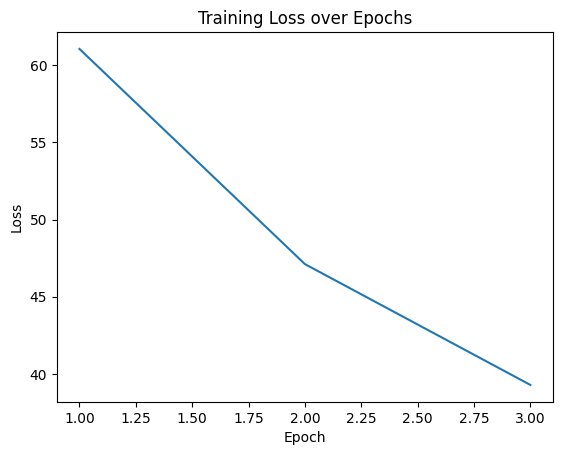

In [19]:
metric_history = train_vqa_model(model, dataloader, tokenizer)

plt.plot(range(1, len(metric_history['loss']) + 1), metric_history['loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.show()

In [23]:
test_vqa_model_on_batch(model, dataloader, tokenizer)

Question: Is the mass calcified?
Generated Answer: yes
Ground Truth Answer: Yes
--------------------------------------------------
Question: Where are the most infiltrates located?
Generated Answer: no
Ground Truth Answer: Left lung
--------------------------------------------------
Question: What is the widened mediastinum caused by?
Generated Answer: no
Ground Truth Answer: mass
--------------------------------------------------
Question: What is the dark structure underneath the skin?
Generated Answer: no
Ground Truth Answer: fat
--------------------------------------------------
Question: Where is the nodule?
Generated Answer: no
Ground Truth Answer: Below the 7th rib in the right lung.
--------------------------------------------------
Question: Is there adequate inspiration?
Generated Answer: no
Ground Truth Answer: Yes
--------------------------------------------------
Question: Are there at least 8 ribs visible for good inspiratory effort?
Generated Answer: no
Ground Truth Answ